# Day 3: Machine Learning

In [234]:
# importing needed libraries globally
from PIL import Image # for reading images
import numpy as np # for arrays manipulations
import matplotlib.pyplot as plt # for 2D plottings
from skimage import color

def red(im):
    """
    Receive multi channels of an image and return the red channel
    """
    return im[:,:,0]
def green(im):
    """
    Receive multi channels of an image and return the green channel
    """
    return im[:,:,1]
def blue(im):
    """
    Receive multi channels of an image and return the blue channel
    """
    return im[:,:,2]

def gray(im):
    """
    Receive multi channels of an image and return a gray
    """
    return color.rgb2gray(im)
def imread(imgfile,numpy=False):
    """
    read an image as numpy array and make it mutatable
    """
    img = Image.open(imgfile)
    if numpy:
        img = np.asarray(img)
        return img.copy()
    else:
        return img
def plot_grid(imarrays,titles,figsize=(10,10)):
    """
    show four images
    """
    count = 1
    plt.figure(figsize=figsize)
    for im,t in zip(imarrays,titles):
        plt.subplot(220+count)
        ax = plt.gca()
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator()) 
        count += 1
        if len(im.shape) < 3:
            plt.imshow(im,cmap="gray")
        else:
            plt.imshow(im)
        plt.title(t, size=20)
    fig.set_tight_layout(True)
    plt.show()

def normalize_img(s):
    """
    Receive image in any data types and range and normalize it
    to [0,255]
    """
    start = 0
    end = 255
    width = end - start
    res = (s - s.min())/(s.max() - s.min()) * width + start
    return res

def plot_hough_lines(img,hough,lines,theta,d):
    """
    Receive image, lines and hough space and plot them next to each other
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()
    # Image
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title('Input image')
    ax[0].set_axis_off()
    # hough space
    ax[1].imshow(space,
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap="gray", aspect=1/1.5)

    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(img, cmap="gray")
    for x0,y0,x1,y1 in lines:
        ax[2].plot((x0,x1), (y0, y1), '-r')
    
    ax[2].set_xlim((0, img.shape[1]))
    ax[2].set_ylim((img.shape[0],0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    plt.show()


## Parametric model

- A parametric model can represent a class of instances where each is defined by a value of the parameters
- Examples include lines, or circles, or even a parameterized template

### Fitting a parametric model
- Choose a parametric model to represent a set of features
- Membership criterion is not local
    - can't tell whether a point in the image belongs to a given model just by looking at that point
- Computational complexity is important
    - not feasible to examine possible parameter setting


### Example: Line fitting using Hough Transform

In [235]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data

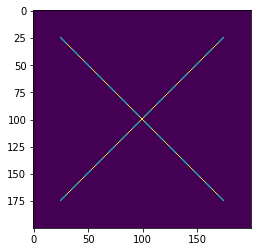

In [236]:
# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255
plt.imshow(image)

In [237]:
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
def find_hough_lines(img,theta_range=[-np.pi / 2, np.pi / 2],num=360,top=10):
    """
    Receive an image and returns lines and the hough space detected using hough transform 
    """
    tested_angles = np.linspace(theta_range[0],theta_range[1], num)
    h, theta, d = hough_line(img, theta=tested_angles)
    origin = np.array((0, img.shape[1]))
    lines = []
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        lines.append((origin[0],y0,origin[1],y1))
    return lines[:top],np.log(1 + h),theta[:top],d[:top]

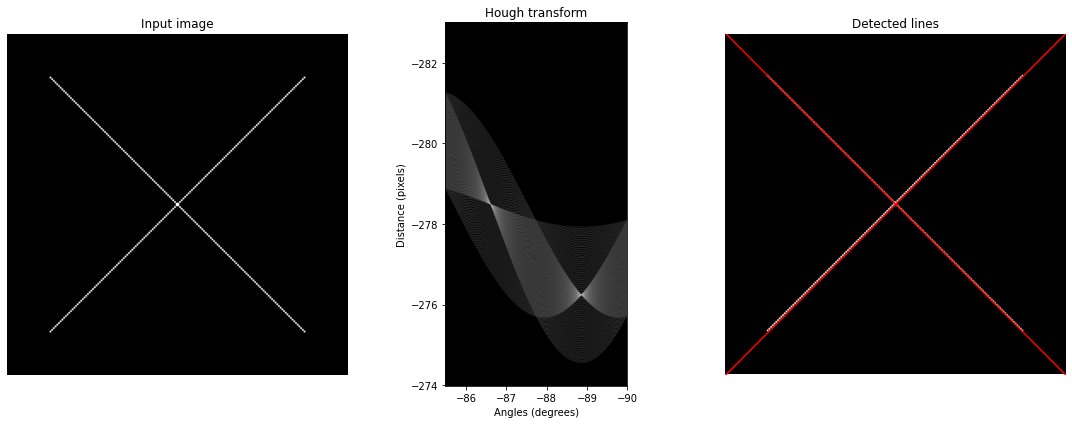

In [238]:
# Find hough lines
lines,space,theta,d = find_hough_lines(image)
# Plot 
plot_hough_lines(image,space,lines,theta,d)

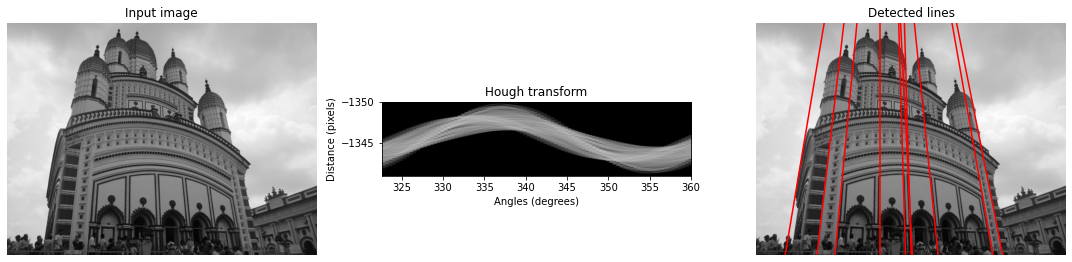

In [239]:
temple = gray(imread("imgs/temple.JPG",True))
# Find hough lines
edges = canny(temple,4)
lines,space,theta,d = find_hough_lines(edges,[np.deg2rad(360),np.deg2rad(-10)],90,top=10)
# Plot 
plot_hough_lines(temple,space,lines,theta,d)

### Example: Circle fitting

In [240]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
def find_hough_circle(img,hough_radii,top=4):
    """
    Receive image, radius search speace, how many to return
    Calculate canny edge, apply find hough circle
    Return centers and radii of the @top found circles
    """
    edges = canny(gray(img), sigma=3)
    # Detect two radii
    hough_res = hough_circle(edges, hough_radii)
    # Select the most prominent top circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=top)

    return cx,cy,radii

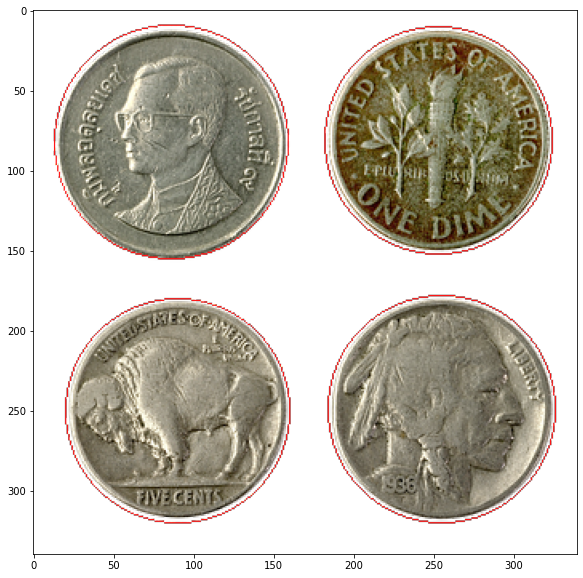

In [241]:
# reading coins image
coins = imread("imgs/coins.png",True)
# search space
hough_radii = np.arange(0, 100, 1)
# finding hough circle
cx, cy, radii = find_hough_circle(coins,hough_radii,top=100)
# selecting top 4
top4 = radii.argsort()[-4:][::-1]
# drawing circle boundries
for center_y, center_x, radius in zip(cy[top4], cx[top4], radii[top4]):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=coins.shape)
    coins[circy, circx] = (255, 20, 20,255)
# plotting
plt.imshow(coins, cmap=plt.cm.gray)
plt.gcf().set_size_inches((10,10))

## Classical Machine Learning Methods in Image Processing

### Dimension reduction and visualization with PCA

In [242]:
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [339]:
def plot_dataset(dataset,nrows,ncols,figsize=(5,5)):
    """
    Receive a dataset and plot random subset of it in grid(nrows,ncols)
    """
    np.random.seed(1)
    j = 1
    fig = plt.figure(figsize=(figsize)) 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
    for i in np.random.choice(dataset.shape[0], nrows*ncols):
        plt.subplot(nrows,ncols,j), plt.imshow(np.reshape(digits.data[i,:], (8,8)), cmap='binary'), plt.axis('off')
        j += 1
    plt.show()

def plot_pca_2(datasets_pca,targets):
    plt.figure(figsize=(15,10))
    plt.scatter(datasets_pca[:, 0], datasets_pca[:, 1], lw=0.25, 
                c=targets, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
    plt.xlabel('PC1', size=20)
    plt.ylabel('PC2', size=20)
    plt.title('2D Projection of handwritten digits with PCA', size=25)
    plt.colorbar(ticks=range(10), label='digit value')
    plt.clim(-0.5, 9.5)

def plot_pca_4(datasets_pca,targets,order=[0,1,2,3]):
    fig, ax = plt.subplots(ncols=2,figsize=(15,10))
    ax[0].scatter(datasets_pca[:, order[0]], datasets_pca[:, order[1]], lw=0.25, 
                c=targets, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
    ax[0].set_xlabel(f'PCA {order[0]+1}', size=20)
    ax[0].set_ylabel(f'PCA {order[1]+1}', size=20)
    
    p1 = ax[1].scatter(datasets_pca[:, order[2]], datasets_pca[:, order[3]], lw=0.25, 
            c=targets, edgecolor='k',  s=100, cmap=plt.cm.get_cmap('cubehelix', 10))
    ax[1].set_xlabel(f'PCA {order[2]+1}', size=20)
    ax[1].set_ylabel(f'PCA {order[3]+1}', size=20)
    fig.colorbar(p1,ticks=range(10), label='')
    #plt.title('4D Projection of handwritten digits with PCA', size=25)
    
    #plt.clim(-0.5, 9.5)

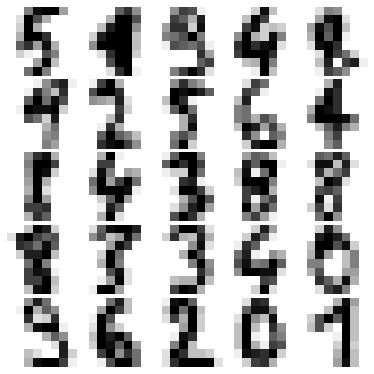

In [256]:
# load digits dataset
digits = load_digits()
# show random 25 subset
plot_dataset(digits.data,5,5)

0.2850936482369694


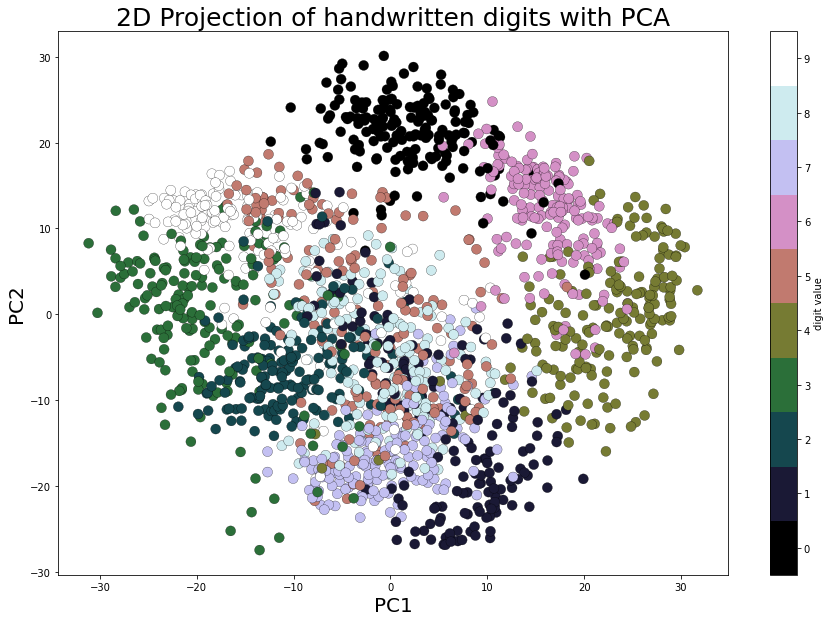

In [258]:
# creating PCA with 2 principles 
pca=PCA(2)
# transform the data with PCA
digits_pca = pca.fit_transform(digits.data) 
# print the principle variance ratio
print(np.sum(pca_digits.explained_variance_ratio_))
# plots the dataset as projected on 2 pcas
plot_pca_2(digits_pca,digits.target)

0.2850936482369694


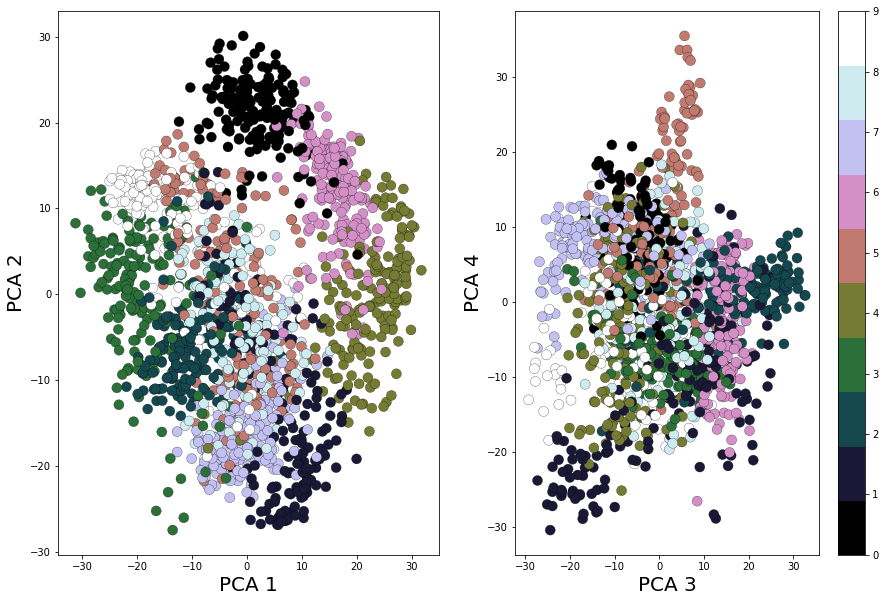

In [341]:
# creating PCA with 4 principles 
pca=PCA(4)
# transform the data with PCA
digits_pca = pca.fit_transform(digits.data) 
# print the principle variance ratio
print(np.sum(pca_digits.explained_variance_ratio_))
# plots the dataset as projected on 2 pcas
plot_pca_4(digits_pca,digits.target,[0,1,2,3])

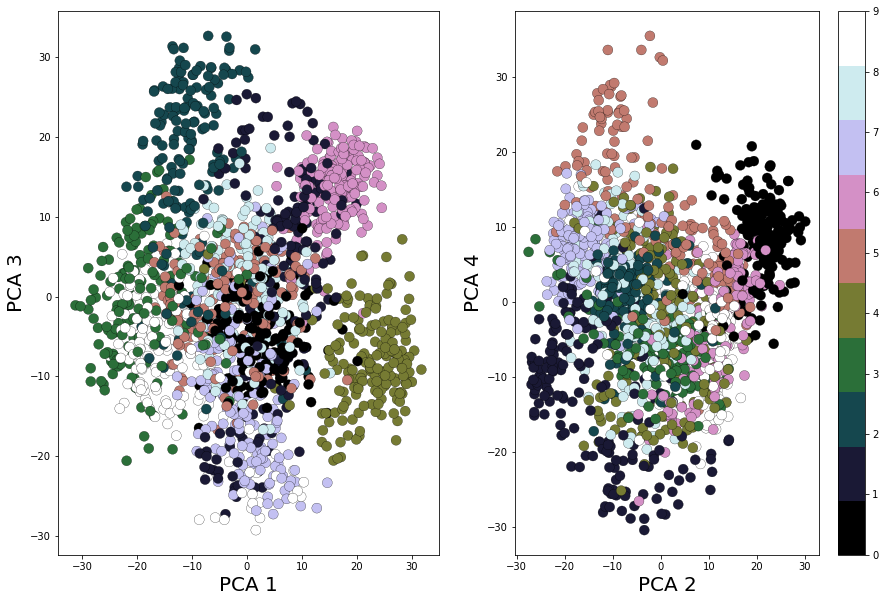

In [340]:
plot_pca_4(digits_pca,digits.target,[0,2,1,3])

<font color="red" size=5pt>checkout eigenfaces as well</font>

### K-Means segmentation with color quantization

In [333]:
from sklearn.cluster import KMeans 

def cluster_kmeans(img_vec,ncolors,nsamples=1000):
    """
    Receive vectorized image, number of colors, and 
        number of sample to train kmeans classifier
    Return labels vector for every element in the vectorized image and the classifier's centers
    """
    samples = img_vec[np.random.choice(img_vec.shape[0], nsamples, replace=False)]
    predictor = KMeans(n_clusters=ncolors, random_state=0).fit(samples)
    labels = predictor.predict(img_vec)
    centers = predictor.cluster_centers_
    return labels,centers

def segment(img,ncolors):
    """
    Receive an image and number of colors
    Return segmented image with n colors using kmeans
    """
    h,w,d = img.shape
    img_vec = img.reshape((-1,d))
    labels,centers = cluster_kmeans(img_vec,ncolors)
    segmented = np.array([centers[l] for l in labels])
    return segmented.reshape(img.shape).astype(np.uint8)

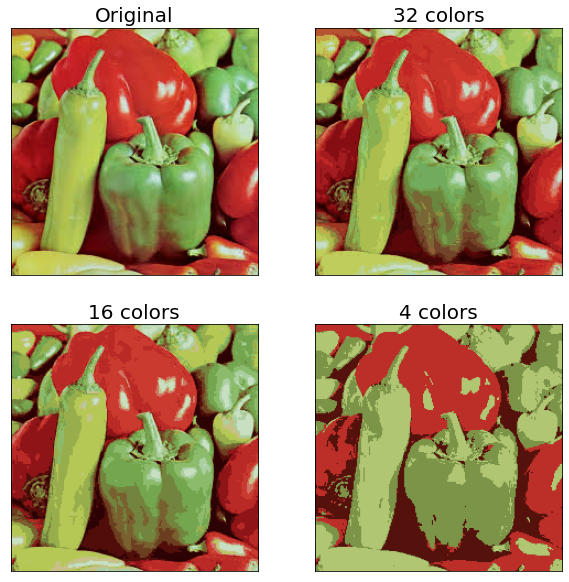

In [332]:
# reading peper image
pepper = imread("imgs/pepper.jpg",True)
# several colors choises
colors = [32,16,4]
# segmented images
segmented = [segment(pepper,c) for c in colors]
# plotting
plot_grid([pepper]+segmented[:3],["Original"]+[f"{c} colors" for c in colors[:3]])

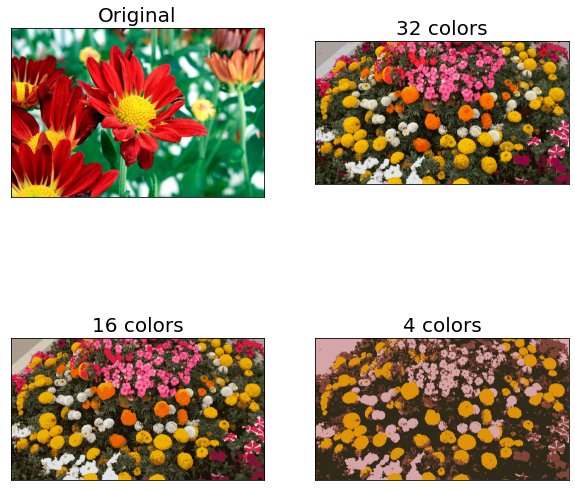

In [335]:
# reading flowers image
flowers = imread("imgs/flowers.png",True)
# several colors choises
colors = [32,16,4]
# segmented images
segmented = [segment(flowers,c) for c in colors]
# plotting
plot_grid([flowers]+segmented[:3],["Original"]+[f"{c} colors" for c in colors[:3]])